In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

In [33]:
LABELS_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/labels/labels_native"
IMAGES_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/image_chips_native-20250212T103727Z-001/image_chips_native"


DEFAULT_METERS_PER_PIXEL = 0.31  

def get_meters_per_pixel(tiff_path):
    
    try:
        with rasterio.open(tiff_path) as src:
            transform = src.transform
            meters_per_pixel = abs(transform.a)  
            return meters_per_pixel
    except Exception as e:
        print(f"Could not read {tiff_path}: {e}")
        return DEFAULT_METERS_PER_PIXEL  

def match_labels_to_images():
   
    
    label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(".txt")])
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(".tif")])
    
    
    label_map = {os.path.splitext(f)[0]: f for f in label_files}
    image_map = {os.path.splitext(f)[0]: f for f in image_files}

    
    matched_pairs = []
    for base_name in label_map:
        if base_name in image_map:  
            matched_pairs.append((label_map[base_name], image_map[base_name]))
            # print(f"Matched: {base_name}")

    return matched_pairs


In [34]:
def analyze_label_distribution(matched_pairs):
    
    label_counts = []
    
    
    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            num_labels = len(file.readlines())
            label_counts.append(num_labels)
    
    
    min_labels = min(label_counts)
    max_labels = max(label_counts)
    
    
    distribution = {}
    for count in range(min_labels, max_labels + 1):
        num_images = label_counts.count(count)
        if num_images > 0:  
            distribution[count] = num_images
    
    
    df = pd.DataFrame.from_dict(distribution, orient='index', columns=['Number of Images'])
    df.index.name = 'Number of Labels'
    
    return df

def count_solar_panels(matched_pairs):
    """Counts total instances of solar panels and label distribution per image."""
    total_instances = 0
    label_counts = []

    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            lines = file.readlines()
            count = sum(1 for line in lines if line.split()[0] == '0')  # Count only instances with class label 0
            total_instances += count
            label_counts.append(count)

    return total_instances, label_counts


In [35]:
matched_pairs = match_labels_to_images()

total_instances, label_counts = count_solar_panels(matched_pairs)

label_distribution = analyze_label_distribution(matched_pairs)

In [36]:
with open('Q1_results.txt', 'w') as f:
    
    f.write(f"Total number of solar panel instances: {total_instances}\n\n")
    
    
    f.write("Distribution of labels per image:\n")
    f.write("--------------------------------\n")
    f.write(label_distribution.to_string())

In [37]:
def compute_area_statistics(matched_pairs):

    areas = []

    for label_file, image_file in matched_pairs:
        image_path = os.path.join(IMAGES_DIR, image_file)
        meters_per_pixel = get_meters_per_pixel(image_path)

        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            for line in file:
                parts = line.strip().split()
                class_label = int(parts[0])  
                
            
                if class_label == 0:
                    _, _, _, width, height = map(float, parts)  
                    
                   
                    width_m = width * meters_per_pixel
                    height_m = height * meters_per_pixel
                    
                    area = width_m * height_m  
                    areas.append(area)

    
    mean_area = np.mean(areas) if areas else 0
    std_area = np.std(areas) if areas else 0

    return areas, mean_area, std_area

def plot_area_histogram(areas):
    """Plots the histogram of computed areas."""
    plt.figure(figsize=(8, 5))
    plt.hist(areas, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Area (sq. meters)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Solar Panel Areas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    


Mean Area: 0.01 sq. meters
Standard Deviation: 0.04 sq. meters


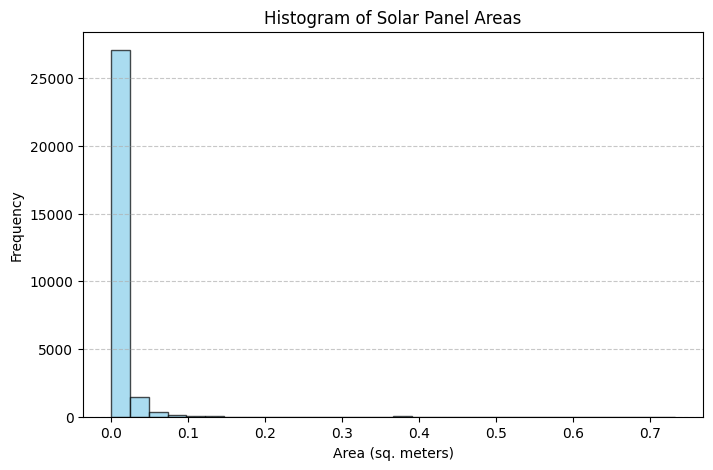

In [38]:
areas, mean_area, std_area = compute_area_statistics(matched_pairs)
print(f"\nMean Area: {mean_area:.2f} sq. meters")
print(f"Standard Deviation: {std_area:.2f} sq. meters")


plot_area_histogram(areas)

# Observations from the Histogram of Solar Panel Areas

- **Highly Skewed Distribution**: The histogram is heavily right-skewed, indicating that most solar panel areas are very small.  
- **Majority of Areas are Small**: A large number of data points fall within the smallest bin, suggesting that most panels in the dataset have very small surface areas.  
- **Few Large Panels**: There are very few instances of larger panel areas (above 0.1 square meters), as seen in the long right tail of the distribution.  
- **Possible Data Issues**: The extreme concentration near zero might indicate:
  - Measurement precision issues.
  - The dataset including many small or partial solar panel installations.
  - Potential data entry inconsistencies.

In [39]:
from shapely.geometry import box
from sklearn.metrics import auc
import random
from shapely.geometry import box 

In [40]:
def compute_iou(box1, box2):
    
    polygon1 = box(*box1)
    polygon2 = box(*box2)
    
    if not polygon1.intersects(polygon2):
        return 0.0
    
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    
    return intersection_area / union_area

def pascal_voc_11_point_ap(recalls, precisions):
    
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 11.0
    return ap

def coco_101_point_ap(recalls, precisions):
   
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 101.0
    return ap

def auc_pr_ap(recalls, precisions):
    
    return auc(recalls, precisions)

def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    
    tp = 0
    fp = 0
    fn = len(gt_boxes)
    
    for pred_box in pred_boxes:
        ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
        if max(ious) >= iou_threshold:
            tp += 1
            fn -= 1
        else:
            fp += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall




In [41]:
def generate_random_boxes(image_size, box_size, num_boxes):
    """Generate random bounding boxes within the given image size."""
    boxes = []
    for _ in range(num_boxes):
        x_min = random.randint(0, image_size - box_size)
        y_min = random.randint(0, image_size - box_size)
        x_max = x_min + box_size
        y_max = y_min + box_size
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes


In [42]:
image_size = 100
box_size = 20
num_images = 10
num_boxes = 10
iou_threshold = 0.5

precisions = []
recalls = []

for _ in range(num_images):
    gt_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    pred_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    
    precision, recall = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Sort by recall
sorted_indices = np.argsort(recalls)
recalls = recalls[sorted_indices]
precisions = precisions[sorted_indices]

ap_voc = pascal_voc_11_point_ap(recalls, precisions)
ap_coco = coco_101_point_ap(recalls, precisions)
ap_auc = auc_pr_ap(recalls, precisions)

print(f"Pascal VOC 11-point AP: {ap_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"AUC-PR AP: {ap_auc:.4f}")

Pascal VOC 11-point AP: 0.0818
COCO 101-point AP: 0.0921
AUC-PR AP: 0.0450


In [ ]:
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import shutil

dataset_dir = os.path.abspath("yolo_dataset")  
  

In [ ]:



for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'labels', split), exist_ok=True)


image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.tif')]

def filter_labels(label_path, output_path):
    """Filter labels to keep only class 0 and write to new file"""
    filtered_lines = []
    try:
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.split()
                if int(parts[0]) == 0:  
                    filtered_lines.append(line)
        
        with open(output_path, 'w') as file:
            file.writelines(filtered_lines)
        return len(filtered_lines) > 0  
    except:
        return False


data = []
for img in image_files:
    label_file = os.path.splitext(img)[0] + ".txt"
    if label_file in os.listdir(LABELS_DIR):
        src_label_path = os.path.join(LABELS_DIR, label_file)
        # Create filtered label in temporary location
        temp_label_path = os.path.join(dataset_dir, 'temp_labels', label_file)
        os.makedirs(os.path.join(dataset_dir, 'temp_labels'), exist_ok=True)
        
        if filter_labels(src_label_path, temp_label_path):
            data.append((img, label_file))

print(f"Total images with class 0 labels: {len(data)}")


train_data, test_data = train_test_split(data, test_size=0.2)

train_data, val_data = train_test_split(train_data, test_size=0.1)


def move_files(data_split, split_name):
    for img, label in data_split:
        
        shutil.copy(os.path.join(IMAGES_DIR, img), 
                   os.path.join(dataset_dir, 'images', split_name, img))
        
        shutil.copy(os.path.join(dataset_dir, 'temp_labels', label),
                   os.path.join(dataset_dir, 'labels', split_name, label))

move_files(train_data, 'train')
move_files(val_data, 'val')
move_files(test_data, 'test')


shutil.rmtree(os.path.join(dataset_dir, 'temp_labels'))


data_yaml = f"""
nc: 1
names: ["solar_panel"]
download: ""
train: {os.path.join(dataset_dir, 'images', 'train')}
val: {os.path.join(dataset_dir, 'images', 'val')}
test: {os.path.join(dataset_dir, 'images', 'test')}
"""

with open(os.path.join(dataset_dir, "data.yaml"), "w") as f:
    f.write(data_yaml)

Total images with class 0 labels: 2527


KeyboardInterrupt: 

In [45]:
print(os.path.exists(os.path.join(dataset_dir, "data.yaml")))  


True


In [46]:
model = YOLO("yolov8s.pt") 
model.train(data=os.path.join(dataset_dir, "data.yaml"), epochs=20, imgsz=416, device="5")
 


New https://pypi.org/project/ultralytics/8.3.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.75 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:5 (NVIDIA A100-PCIE-40GB, 40338MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=5, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train... 2320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2320/2320 [00:07<00:00, 291.85it/s]


train: New cache created: /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train.cache


val: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/val.cache... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.12G      1.773      1.769      1.307        175        416:  68%|██████▊   | 98/145 [00:45<00:15,  2.96it/s][ WARN:0@1164.458] global grfmt_tiff.cpp:833 readData OpenCV TIFF(line 833): failed TIFFReadRGBAStrip(tif, y, (uint32_t*)src_buffer)
[ERROR:0@1164.470] global loadsave.cpp:507 imread_ imread_('/fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif'): can't read data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:833: error: (-2:Unspecified error) OpenCV TIFF: failed TIFFReadRGBAStrip(tif, y, (uint32_t*)src_buffer) in function 'readData'

       1/20      2.12G      1.727       1.66      1.278        172        416:  77%|███████▋  | 112/145 [00:50<00:14,  2.24it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 288, in __getitem__
    return self.transforms(self.get_image_and_label(index))
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 294, in get_image_and_label
    label["img"], label["ori_shape"], label["resized_shape"] = self.load_image(index)
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 165, in load_image
    raise FileNotFoundError(f"Image Not Found {f}")
FileNotFoundError: Image Not Found /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif


In [ ]:
!grep -r "^[1-9]" /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train/


In [ ]:
import cv2

In [ ]:
def yolo_to_xyxy(x, y, w, h, img_width, img_height):
    
    x1 = (x - w/2) * img_width
    y1 = (y - h/2) * img_height
    x2 = (x + w/2) * img_width
    y2 = (y + h/2) * img_height
    return [x1, y1, x2, y2]

def visualize_predictions(image_path, pred_boxes, gt_boxes, save_dir="predictions"):
    
    os.makedirs(save_dir, exist_ok=True)
    
    image = cv2.imread(image_path)
    image_copy = image.copy()  
    
    
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Add "GT" label
        cv2.putText(image_copy, "GT", (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)
    
    
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        
        cv2.putText(image_copy, "Pred", (x_min, y_max+15), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 0, 255), 2)
    
    
    base_name = os.path.basename(image_path)
    save_path = os.path.join(save_dir, f"pred_{base_name}")
    cv2.imwrite(save_path, image_copy)
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"Green: Ground Truth | Red: Predictions\nSaved as: {save_path}")
    plt.axis("off")
    plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")


test_images_dir = "yolo_dataset/images/test"
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) 
               if f.endswith('.tif')]


selected_images = random.sample(test_images, 5)

In [ ]:
for image_path in selected_images:
    
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape
    
    
    results = model(image_path)
    predictions = results[0]
    
    
    pred_boxes = []
    for box in predictions.boxes.xywhn.cpu().numpy():
        x, y, w, h = box
        pred_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    
    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")
    
   
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                gt_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
   
    visualize_predictions(image_path, pred_boxes, gt_boxes)

In [48]:
from tabulate import tabulate
from tqdm import tqdm
import supervision as sv

In [ ]:
import csv

In [49]:
import numpy as np
import torch
import os
import random
import cv2
from ultralytics import YOLO
from tabulate import tabulate



model = YOLO("runs/detect/train/weights/best.pt")


def yolo_to_xyxy(x, y, w, h, img_width, img_height):
    x1 = (x - w/2) * img_width
    y1 = (y - h/2) * img_height
    x2 = (x + w/2) * img_width
    y2 = (y + h/2) * img_height
    return [x1, y1, x2, y2]


def get_boxes(image_path):
    
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape
    
    
    results = model(image_path)
    predictions = results[0]
    
    
    pred_boxes = []
    for box in predictions.boxes.xywhn.cpu().numpy():
        x, y, w, h = box
        pred_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    
    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")
    
    
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                gt_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    return gt_boxes, pred_boxes


test_images_dir = "yolo_dataset/images/test"
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.tif')]


selected_images = random.sample(test_images, 5)


all_gt_boxes = []
all_pred_boxes = []
for image_path in selected_images:
    gt_boxes, pred_boxes = get_boxes(image_path)
    all_gt_boxes.append(gt_boxes)
    all_pred_boxes.append(pred_boxes)


precisions = []
recalls = []

for gt_boxes, pred_boxes in zip(all_gt_boxes, all_pred_boxes):
    precision, recall = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)


sorted_indices = np.argsort(recalls)
recalls = recalls[sorted_indices]
precisions = precisions[sorted_indices]

ap_voc = pascal_voc_11_point_ap(recalls, precisions)
ap_coco = coco_101_point_ap(recalls, precisions)
ap_auc = auc_pr_ap(recalls, precisions)


mAP50 = np.mean([ap_voc, ap_coco, ap_auc])


print(f"Pascal VOC 11-point AP: {ap_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"AUC-PR AP: {ap_auc:.4f}")
print(f"mAP50: {mAP50:.4f}")


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7208_y0_12603_dxdy_416.tif: 416x416 3 solar_panels, 50.1ms
Speed: 3.7ms preprocess, 50.1ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8118_y0_12114_dxdy_416.tif: 416x416 10 solar_panels, 21.5ms
Speed: 4.0ms preprocess, 21.5ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_3768_y0_12575_dxdy_416.tif: 416x416 2 solar_panels, 58.4ms
Speed: 2.2ms preprocess, 58.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5978_y0_3582_dxdy_416.tif: 416x416 10 solar_panels, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 1.8ms p

In [ ]:
import supervision as sv
from supervision.metrics import MeanAveragePrecision

def process_image_directory(image_dir):
  
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(".tif")]
    all_gt_detections = []
    all_pred_detections = []

    for image_name in tqdm(image_files, desc="Processing Images"):
        image_path = os.path.join(image_dir, image_name)
        gt_detections, pred_detections = get_detections(image_path)
        all_gt_detections.append(gt_detections)
        all_pred_detections.append(pred_detections)

    return all_gt_detections, all_pred_detections

def get_detections(image_path):
   
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    results = model(image_path)
    predictions = results[0]

    pred_xyxy = predictions.boxes.xyxy.cpu().numpy()
    pred_conf = predictions.boxes.conf.cpu().numpy()
    pred_cls = predictions.boxes.cls.cpu().numpy().astype(int)

    pred_detections = sv.Detections(
        xyxy=pred_xyxy,
        confidence=pred_conf,
        class_id=pred_cls,
    )

    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")

    gt_xyxy = []
    gt_cls = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                gt_xyxy.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
                gt_cls.append(int(class_id))

    gt_detections = sv.Detections(
        xyxy=np.array(gt_xyxy),
        class_id=np.array(gt_cls),
    )

    return gt_detections, pred_detections


targets,predictions=process_image_directory("yolo_dataset/images/test")

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

def print_to_file(f, c): open(f, 'w').write(str(c) + '\n')

print_to_file("output.txt", map_result)

In [47]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=['solar_panel'],
    conf_threshold=0.5,
    iou_threshold=0.3
)

print(confusion_matrix.matrix)

[[       5596         434]
 [        242           0]]


In [51]:
import numpy as np
import supervision as sv
import pandas as pd

def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]


data = []

for iou_thresh in iou_thresholds:
    for conf_thresh in confidence_thresholds:
        confusion_matrix = sv.ConfusionMatrix.from_detections(
            predictions=predictions,
            targets=targets,
            classes=['solar_panel'],
            conf_threshold=conf_thresh,
            iou_threshold=iou_thresh
        )
        
        matrix = confusion_matrix.matrix
        tp = np.diag(matrix).sum()
        fp = matrix.sum(axis=0) - np.diag(matrix)
        fn = matrix.sum(axis=1) - np.diag(matrix)
        fp, fn = fp.sum(), fn.sum()
        
        precision, recall, f1_score = compute_metrics(tp, fp, fn)
        data.append([iou_thresh, conf_thresh, precision, recall, f1_score])


df = pd.DataFrame(data, columns=["IoU Threshold", "Confidence Threshold", "Precision", "Recall", "F1-Score"])
df.to_csv("metrics_results.csv", index=False)


print("\nPrecision, Recall, F1-score Table")
print(df)



Precision, Recall, F1-score Table
    IoU Threshold  Confidence Threshold  Precision    Recall  F1-Score
0             0.1                   0.1   0.848476  0.848476  0.848476
1             0.1                   0.3   0.864667  0.864667  0.864667
2             0.1                   0.5   0.892521  0.892521  0.892521
3             0.1                   0.7   0.764067  0.764067  0.764067
4             0.1                   0.9   0.166142  0.166142  0.166142
5             0.3                   0.1   0.848476  0.848476  0.848476
6             0.3                   0.3   0.864389  0.864389  0.864389
7             0.3                   0.5   0.892219  0.892219  0.892219
8             0.3                   0.7   0.764067  0.764067  0.764067
9             0.3                   0.9   0.166142  0.166142  0.166142
10            0.5                   0.1   0.839890  0.839890  0.839890
11            0.5                   0.3   0.855255  0.855255  0.855255
12            0.5                   0.5   